In [1]:
# Analysis for the air passengers data set:
# https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis

In [2]:
#!pip install pmdarima

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
# Plot time series
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"])
df.set_index("Month",inplace=True)
df = df.rename(columns={"#Passengers":"Passengers"})
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


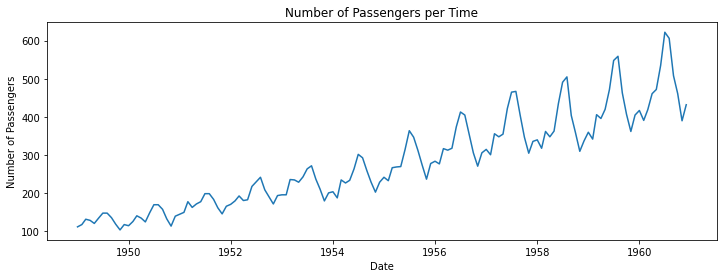

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.title("Number of Passengers per Time")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.show()

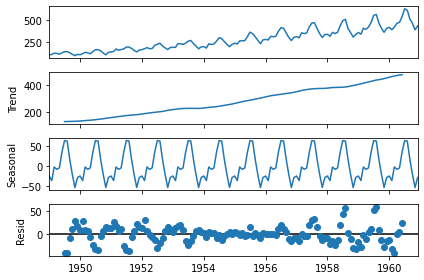

In [36]:
# Decompose the time series

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

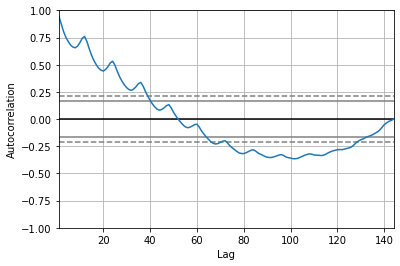

In [37]:
# Calculate and plot ACF
pd.plotting.autocorrelation_plot(df['Passengers'])

In [38]:
df['Passengers'].corr(df['Passengers'].shift(60))

0.9632642547640052

In [39]:
# Check, if the time series is stationary (using Augmented Dickey-Fuller (ADF) test)

test_results = adfuller(df['Passengers'])
print('ADF Statistic: ', test_results[0])
print('P-Value: ', test_results[1])

ADF Statistic:  0.8153688792060441
P-Value:  0.9918802434376409


In [40]:
# pvalue = 0.99 thats mean the data is not stationary. 

<AxesSubplot:xlabel='Month'>

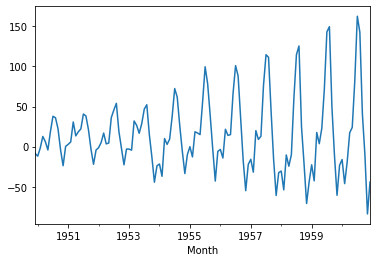

In [42]:
# If there is the trend - remove it from the Time Series
# There is a positive trend 

rolling_mean = df['Passengers'].rolling(window=12).mean()
data_no_trend = df['Passengers'] - rolling_mean
data_no_trend = data_no_trend[data_no_trend.notnull()]
data_no_trend = data_no_trend.dropna()
data_no_trend.plot()

In [43]:
test_results = adfuller(data_no_trend)
print('ADF Statistic: ', test_results[0])
print('P-Value: ', test_results[1])

ADF Statistic:  -3.1649681299551453
P-Value:  0.022104139473878834


In [44]:
# # the data is stationary now p-value  = 0.02

<AxesSubplot:xlabel='Month'>

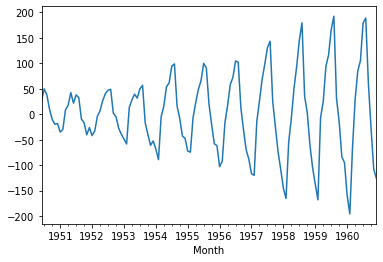

In [47]:
# Check seasonality 
data_cleared = data_no_trend.diff(periods=6)
data_cleared = data_cleared[data_cleared.notnull()]
data_cleared.plot()

In [48]:
# Run automatic ARIMA model determination. Find the best model, give summary and display the results 
# (existing time range + future)

In [49]:
model = auto_arima(data_cleared,trace=True,suppress_warnings=True)
results = model.fit(data_cleared)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1190.404, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1470.643, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1348.163, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1468.703, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1328.123, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 6.668 seconds


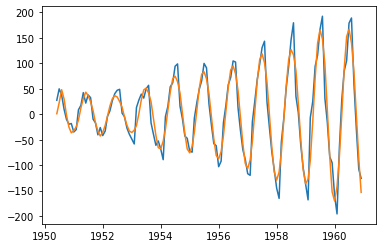

In [50]:
#SARIMAx(2,0,2)

plt.plot(data_cleared)
plt.plot(results.fittedvalues())

In [51]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -589.202
Date:                Sun, 23 Jul 2023   AIC                           1190.404
Time:                        19:58:40   BIC                           1207.469
Sample:                    06-01-1950   HQIC                          1197.337
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2287      0.910      0.251      0.802      -1.555       2.012
ar.L1          1.7273      0.008    230.115      0.000       1.713       1.742
ar.L2         -0.9967      0.006   -172.470      0.000      -1.008      -0.985
ma.L1         -1.5563      0.046    -33.829      0.000      -1.646      -1.466
ma.L2          0.9668      0.053     18.382      0.000       0.864       1.070
sigma2       582.4973     66.714      8.731      0.000     451.739     713.255
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 5.63
Prob(Q):                              0.70   Prob(JB):                         0.06
Heteroskedasticity (H):               4.90   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
model = auto_arima(df,trace=True,suppress_warnings=True)
results = model.fit(df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1403.473, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1398.827, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.121, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1398.386, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.975, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1394.683, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1397.258, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1401.852, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1378.338, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.5

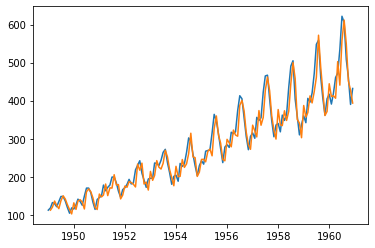

In [53]:
plt.plot(df)
fitted_vals = results.fittedvalues()
fitted_vals = fitted_vals[1:]
plt.plot(fitted_vals)

In [54]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(4, 1, 3)   Log Likelihood                -674.913
Date:                Sun, 23 Jul 2023   AIC                           1365.825
Time:                        20:01:03   BIC                           1389.528
Sample:                    01-01-1949   HQIC                          1375.457
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.332      -0.126       0.374
ar.L4         -0.5213      0.085     -6.136      0.000      -0.688      -0.355
ma.L1          0.9069      0.094      9.657      0.000       0.723       1.091
ma.L2         -0.5590      0.145     -3.866      0.000      -0.842      -0.276
ma.L3         -0.7385      0.109     -6.778      0.000      -0.952      -0.525
sigma2       724.1728     85.616      8.458      0.000     556.369     891.976
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                14.59
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the SARIMAX model analysis for airline passenger data, it can be concluded that the model exhibits a good fit with the test data. The model doesn't cach very low and very high values, but works well with original data.